Simulation of Hull-White 1-factor model
==

This notebook demonstrates 
1. The fitting of the model to a zero curve (in this case the ESTR curve as of 1 April 2024).
2. Simulation of the short rate process under the Hull-White 1-factor model.

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from frm.term_structures.zero_curve import ZeroCurve
from frm.pricing_engine.hw1f import HullWhite1Factor
from frm.utils.daycount import year_fraction
from frm.enums.utils import DayCountBasis
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# ESTR swap curve on 1 April 2024
curve_date = pd.Timestamp('2024-04-01')
df = pd.DataFrame({
    'tenor': ['ON', 'SW', '2W', '3W', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '12M', '15M', '18M', '21M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '11Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
    'date': pd.to_datetime(['2-Apr-2024', '10-Apr-2024', '17-Apr-2024', '24-Apr-2024', '3-May-2024', '3-Jun-2024', '3-Jul-2024', '5-Aug-2024', '3-Sep-2024', '3-Oct-2024', '4-Nov-2024', '3-Dec-2024', '3-Jan-2025', '3-Feb-2025', '3-Mar-2025', '3-Apr-2025', '3-Jul-2025', '3-Oct-2025', '5-Jan-2026', '7-Apr-2026', '5-Apr-2027', '3-Apr-2028', '3-Apr-2029', '3-Apr-2030', '3-Apr-2031', '5-Apr-2032', '4-Apr-2033', '3-Apr-2034', '3-Apr-2035', '3-Apr-2036', '4-Apr-2039', '4-Apr-2044', '5-Apr-2049', '3-Apr-2054']),
    'discount_factor': [0.999892, 0.999026, 0.998266, 0.997514, 0.996546, 0.993222, 0.99014, 0.98688, 0.984079, 0.981287, 0.978453, 0.975944, 0.973358, 0.970875, 0.968705, 0.966373, 0.959921, 0.954107, 0.948336, 0.942805, 0.922607, 0.903406, 0.884216, 0.864765, 0.845061, 0.824882, 0.804566, 0.783991, 0.763235, 0.742533, 0.683701, 0.605786, 0.54803, 0.500307]
})
df['years'] = year_fraction(curve_date, df['date'], DayCountBasis.ACT_ACT)

zero_curve = ZeroCurve(curve_date=curve_date,
               data=df[['years','discount_factor']],
               interpolation_method='cubic_spline_on_zero_rates')

Initialise the HW1F model.

In this example we have specified the mean reversion level and volatility of the short rate process.

In other examples, we will calibrate these parameters to quoted instruments.

In [2]:
# HW1F model parameters
short_rate_mean_rev_lvl = 0.05 # Standard values are 1%-10% annualized
short_rate_vol = 0.0196 # Standard values are 1%-10% annualized
hw1f = HullWhite1Factor(zero_curve=zero_curve, mean_rev_lvl=short_rate_mean_rev_lvl, vol=short_rate_vol)

In [3]:
# Fit the model to the zero curve
grid_length = 50
hw1f.setup_theta(num=grid_length)

# Demonstrate the fit of the model to the zero curve with a table of the errors (in basis points ) for each source data point
avg_error_bps = hw1f.calc_error_for_theta_fit(print_results=True)


Differences b/t pillar zero rates and theta fit for: dt=0.0001 and num=1000
Average error (bps): 0.005752
+---------+-----------------+-----------------+-------------+
|  Years  | Pillar CCZR (%) | Recalc CCZR (%) | Diff. (bps) |
+---------+-----------------+-----------------+-------------+
| 0.00273 |      3.953      |      3.953      |     0.0     |
|  0.0246 |      3.9629     |      3.9629     |     0.0     |
|  0.0437 |       3.97      |       3.97      |     0.0     |
|  0.0628 |      3.9609     |      3.9609     |     0.0     |
|  0.0874 |      3.9574     |      3.9574     |     0.0     |
|  0.172  |      3.9511     |      3.9511     |     0.0     |
|  0.254  |      3.8996     |      3.8996     |     0.0     |
|  0.344  |      3.8363     |      3.8363     |     0.0     |
|  0.423  |      3.7897     |      3.7896     |     0.0     |
|  0.505  |      3.7372     |      3.7372     |     0.0     |
|  0.593  |      3.6739     |      3.6739     |     0.0     |
|  0.672  |      3.6228  

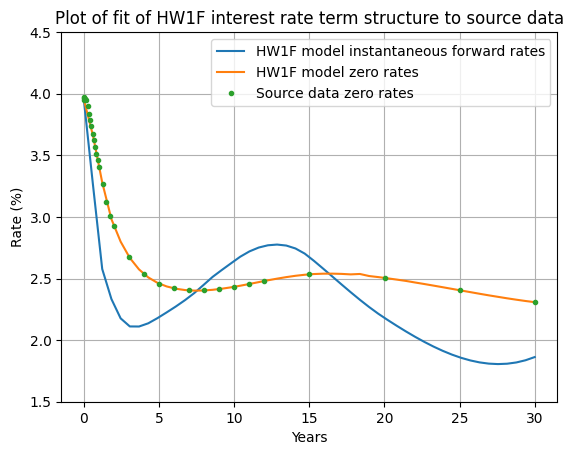

In [4]:
# Demonstrate the fit of the model with plot of the zero curve and the model zero curve
years_grid = np.linspace(zero_curve.data['years'].min(), zero_curve.data['years'].max(),grid_length)
hw1f_instantaneous_forward_rate  = [hw1f.get_instantaneous_forward_rate(t) for t in years_grid]
hw1f_zero_rates = [hw1f.get_zero_rate(0,t) for t in years_grid]
hw1f_discount_factors = [hw1f.get_discount_factor(0, t) for t in years_grid]

plt.figure()
plt.plot(years_grid, 100 * np.array(hw1f_instantaneous_forward_rate), label ='HW1F model instantaneous forward rates')
plt.plot(years_grid, 100 * np.array(hw1f_zero_rates), label='HW1F model zero rates')
plt.plot(zero_curve.data['years'], 100 * zero_curve.data['nacc'].values, marker='.', linestyle='None', label='Source data zero rates')
plt.ylim(1.5,4.5)

plt.xlabel(r'Years')
plt.title(r'Plot of fit of HW1F interest rate term structure to source data')
plt.grid(True)
plt.legend()
plt.ylabel('Rate (%)')
plt.show()

Simulate the short rate process under the Hull-White 1-factor model.
Each simulation produces a timeseries of the rate process (technically not the short rate but with a small enough time step it is a good approximation). This rate process is then integrated to produce a time series of discount factors / zero rates. 
 
The simulation average over the discount factors converges to the model discount factors (i.e. the model discount bond prices).  
We demonstrate convergence by plotting the average zero rates from the simulations against the source data's zero rates as it is a better visual representation of the convergence than plotting discount factors.


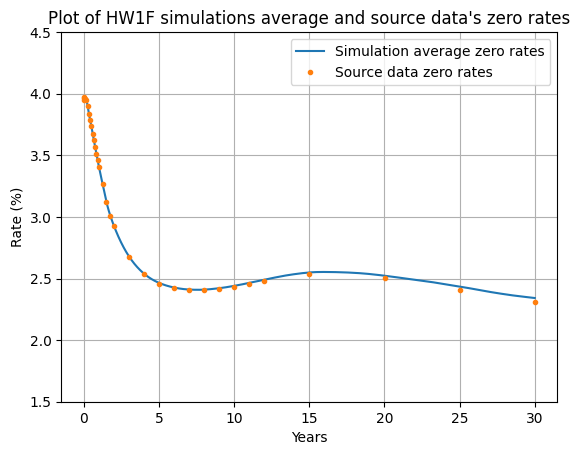

In [5]:
# Demonstrate the HW1F simulations average zero rate matches the source data's zero rates
nb_simulations = 5000
nb_steps = pd.date_range(start=curve_date, end=df['date'].max()).shape[0]-1 # Daily Steps

results = hw1f.simulate(tau=df['years'].max(),
                        nb_steps=nb_steps,
                        nb_simulations=nb_simulations,
                        flag_apply_antithetic_variates=True,
                        random_seed=1500)

plt.figure()
sim_avg_zero_rates = 100 * results['averages_df']['cczr'].values
years_grid = results['averages_df']['years'].values
plt.plot(years_grid, sim_avg_zero_rates, label='Simulation average zero rates')
plt.plot(zero_curve.data['years'], 100 * zero_curve.data['nacc'].values, marker='.', linestyle='None', label='Source data zero rates')
plt.ylim(1.5,4.5)
plt.xlabel(r'Years')
plt.title(r"Plot of HW1F simulations average and source data's zero rates")
plt.grid(True)
plt.legend()
plt.ylabel('Rate (%)')
plt.show()
